In [1]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim_1, hidden_dim_2, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim_1)
        self.lin2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.lin3 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.lin4 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        # act_funtion = F.sigmoid oder F.relu
        x = self.act_function(self.lin1(x))
        x = self.act_function(self.lin2(x))
        x = self.act_function(self.lin3(x))
        x = self.lin4(x)
        return x

In [3]:
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [8]:
def make_data(dataset, features, batch_size, debug=False):
    datasets = []
    for file in dataset:
        datasets.append(pd.read_csv("../" + file))
    dataset = pd.concat(datasets, axis=0, ignore_index=True)
    
    target = dataset["affect"]
    dataset_full = dataset[["word_count", "upper_word_count", "ent_word_count", "h_count", "s_count", "a_count", "f_count", "cons_punct_count"]]
    dataset_nolex = dataset[["word_count", "upper_word_count", "ent_word_count", "cons_punct_count"]]
    dataset_lex = dataset[["h_count", "s_count", "a_count", "f_count"]]
    
    # make train and test sets
    if features == "full": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.2)
    elif features == "nolex":
        train_x, test_x, train_y, test_y = train_test_split(dataset_nolex, target, test_size=0.2)
    elif features == "lex": 
        train_x, test_x, train_y, test_y = train_test_split(dataset_lex, target, test_size=0.2)

    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    
    if debug: 
        dataset_full = dataset_full.iloc[:10]
        target = target[:10]
        train_x, test_x, train_y, test_y = train_test_split(dataset_full, target, test_size=0.8)
        train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
        test_loader = DataLoader(dataset=train_data, batch_size=1)
    return train_loader, test_loader 

In [5]:
def log(summary, file):
    log = open(file, "a")
    log.write(summary)
    log.close()
    print(summary)

In [6]:
def train(train_loader, net, epochs, criterion, print_every, save_name, cuda, lr):
    open(save_name + "_train_log", "w").close()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.5)
    error_curve = []
    net.train()
    for epoch in range(epochs):
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float(), targets.long()
            if cuda: 
                inputs = inputs.cuda()
                targets = targets.cuda()
                net = net.cuda()
            pred = net(inputs)
            loss = criterion(pred.float(), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ((index) % print_every == 0):
                log("batch: {}/{} in epoch {}/{} \n... loss: {}\n".
                    format((index+1), len(train_loader), (epoch+1), epochs, loss.item()), 
                    save_name + "_train_log")
        # save network after every epoch
        torch.save(net.state_dict(), save_name + ".pt")  
        # after every epoch save the error
        error_curve.append([epoch, loss.item()])
    log("\n" + str(error_curve), save_name + "_train_log")
    return error_curve

def test(test_loader, net, criterion, print_every, save_name, cuda):
    open(save_name + "_test_log", "w").close()
    confusion = []
    net.eval()
    loss_sum, correct, correct2 = 0, 0, 0
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.float(), targets.long()
        if cuda: 
            inputs = inputs.cuda()
            targets = targets.cuda()
            net = net.cuda()
        pred = net(inputs)
        pred_class = torch.max(pred.data, 1)[1]
        loss_sum += criterion(pred, targets).item()
        confusion.append([targets.item(), pred_class.item()])
        if pred_class.item() == targets.item(): 
            correct += 1
        if ((index) % print_every == 0):
            log("batch: {}/{}\n... correct: {}\n".
                format((index+1), len(test_loader), correct), 
                save_name + "_test_log")
           
    # give end report
    log("average test loss: {}, relative correct: {}\n\nconfusion:\n{}".
        format((loss_sum / len(test_loader)), (correct / len(test_loader)),str(confusion)), 
        save_name + "test_log")

In [9]:
# create variables 
print("creating variables")
emotion_dataset = ["emotion_classification_1_clean.csv", "emotion_classification_2_clean.csv", "emotion_classification_3_clean.csv", "emotion_classification_4_clean.csv", "emotion_classification_5_clean.csv", "emotion_classification_6_clean.csv", "emotion_classification_7_clean.csv", "emotion_classification_8_clean.csv"]
tweet_dataset = ["crowdflower_clean.csv", "emoint_clean.csv", "tec_clean.csv"]
act_function = torch.sigmoid
criterion = nn.CrossEntropyLoss()
cuda = torch.cuda.is_available()

# create datasets
print("creating datasets")
train_loader_emotion_full, test_loader_emotion_full = make_data(emotion_dataset, "full", 25)
train_loader_emotion_nolex, test_loader_emotion_nolex = make_data(emotion_dataset, "nolex", 25)
train_loader_emotion_lex, test_loader_emotion_lex = make_data(emotion_dataset, "lex", 25)
train_loader_tweet_full, test_loader_tweet_full = make_data(tweet_dataset, "full", 25)
train_loader_tweet_nolex, test_loader_tweet_nolex = make_data(tweet_dataset, "nolex", 25)
train_loader_tweet_lex, test_loader_tweet_lex = make_data(tweet_dataset, "lex", 25)
train_loader_debug, test_loader_debug = make_data(emotion_dataset, "full", 25, True)
print("... done")

creating variables
creating datasets
... done


batch: 1/1 in epoch 1/1000 
... loss: 1.3954212665557861

batch: 1/1 in epoch 2/1000 
... loss: 1.0358177423477173

batch: 1/1 in epoch 3/1000 
... loss: 0.838057816028595

batch: 1/1 in epoch 4/1000 
... loss: 0.767345666885376

batch: 1/1 in epoch 5/1000 
... loss: 0.7394106984138489

batch: 1/1 in epoch 6/1000 
... loss: 0.7265515923500061

batch: 1/1 in epoch 7/1000 
... loss: 0.7199903726577759

batch: 1/1 in epoch 8/1000 
... loss: 0.7159444689750671

batch: 1/1 in epoch 9/1000 
... loss: 0.7132539749145508

batch: 1/1 in epoch 10/1000 
... loss: 0.7113291025161743

batch: 1/1 in epoch 11/1000 
... loss: 0.709815263748169

batch: 1/1 in epoch 12/1000 
... loss: 0.7085855603218079

batch: 1/1 in epoch 13/1000 
... loss: 0.7075489163398743

batch: 1/1 in epoch 14/1000 
... loss: 0.7066484689712524

batch: 1/1 in epoch 15/1000 
... loss: 0.7058560848236084

batch: 1/1 in epoch 16/1000 
... loss: 0.7051486968994141

batch: 1/1 in epoch 17/1000 
... loss: 0.7045108675956726

batch: 1/

batch: 1/1 in epoch 142/1000 
... loss: 0.6882734894752502

batch: 1/1 in epoch 143/1000 
... loss: 0.6881700754165649

batch: 1/1 in epoch 144/1000 
... loss: 0.6880654096603394

batch: 1/1 in epoch 145/1000 
... loss: 0.6879596710205078

batch: 1/1 in epoch 146/1000 
... loss: 0.6878525614738464

batch: 1/1 in epoch 147/1000 
... loss: 0.6877443790435791

batch: 1/1 in epoch 148/1000 
... loss: 0.6876347064971924

batch: 1/1 in epoch 149/1000 
... loss: 0.6875240206718445

batch: 1/1 in epoch 150/1000 
... loss: 0.6874117851257324

batch: 1/1 in epoch 151/1000 
... loss: 0.6872982978820801

batch: 1/1 in epoch 152/1000 
... loss: 0.6871834993362427

batch: 1/1 in epoch 153/1000 
... loss: 0.6870672702789307

batch: 1/1 in epoch 154/1000 
... loss: 0.6869496703147888

batch: 1/1 in epoch 155/1000 
... loss: 0.6868302822113037

batch: 1/1 in epoch 156/1000 
... loss: 0.6867097616195679

batch: 1/1 in epoch 157/1000 
... loss: 0.6865875124931335

batch: 1/1 in epoch 158/1000 
... loss: 

batch: 1/1 in epoch 301/1000 
... loss: 0.5996556282043457

batch: 1/1 in epoch 302/1000 
... loss: 0.5975608229637146

batch: 1/1 in epoch 303/1000 
... loss: 0.5954129099845886

batch: 1/1 in epoch 304/1000 
... loss: 0.5932103395462036

batch: 1/1 in epoch 305/1000 
... loss: 0.5909521579742432

batch: 1/1 in epoch 306/1000 
... loss: 0.5886367559432983

batch: 1/1 in epoch 307/1000 
... loss: 0.5862628817558289

batch: 1/1 in epoch 308/1000 
... loss: 0.5838288068771362

batch: 1/1 in epoch 309/1000 
... loss: 0.5813336372375488

batch: 1/1 in epoch 310/1000 
... loss: 0.5787758231163025

batch: 1/1 in epoch 311/1000 
... loss: 0.5761537551879883

batch: 1/1 in epoch 312/1000 
... loss: 0.5734660625457764

batch: 1/1 in epoch 313/1000 
... loss: 0.5707117319107056

batch: 1/1 in epoch 314/1000 
... loss: 0.5678892135620117

batch: 1/1 in epoch 315/1000 
... loss: 0.564996600151062

batch: 1/1 in epoch 316/1000 
... loss: 0.5620331764221191

batch: 1/1 in epoch 317/1000 
... loss: 0

batch: 1/1 in epoch 488/1000 
... loss: 0.025881756097078323

batch: 1/1 in epoch 489/1000 
... loss: 0.025564290583133698

batch: 1/1 in epoch 490/1000 
... loss: 0.02525317296385765

batch: 1/1 in epoch 491/1000 
... loss: 0.02494823932647705

batch: 1/1 in epoch 492/1000 
... loss: 0.024649258702993393

batch: 1/1 in epoch 493/1000 
... loss: 0.024356123059988022

batch: 1/1 in epoch 494/1000 
... loss: 0.02406877651810646

batch: 1/1 in epoch 495/1000 
... loss: 0.02378688007593155

batch: 1/1 in epoch 496/1000 
... loss: 0.023510374128818512

batch: 1/1 in epoch 497/1000 
... loss: 0.023239150643348694

batch: 1/1 in epoch 498/1000 
... loss: 0.022973153740167618

batch: 1/1 in epoch 499/1000 
... loss: 0.022712038829922676

batch: 1/1 in epoch 500/1000 
... loss: 0.022455811500549316

batch: 1/1 in epoch 501/1000 
... loss: 0.022204354405403137

batch: 1/1 in epoch 502/1000 
... loss: 0.021957499906420708

batch: 1/1 in epoch 503/1000 
... loss: 0.021715134382247925

batch: 1/1 i

batch: 1/1 in epoch 623/1000 
... loss: 0.008470853790640831

batch: 1/1 in epoch 624/1000 
... loss: 0.008422862738370895

batch: 1/1 in epoch 625/1000 
... loss: 0.00837522279471159

batch: 1/1 in epoch 626/1000 
... loss: 0.008328231051564217

batch: 1/1 in epoch 627/1000 
... loss: 0.008281532675027847

batch: 1/1 in epoch 628/1000 
... loss: 0.008235422894358635

batch: 1/1 in epoch 629/1000 
... loss: 0.008189667016267776

batch: 1/1 in epoch 630/1000 
... loss: 0.0081444401293993

batch: 1/1 in epoch 631/1000 
... loss: 0.008099507540464401

batch: 1/1 in epoch 632/1000 
... loss: 0.00805516354739666

batch: 1/1 in epoch 633/1000 
... loss: 0.008011113852262497

batch: 1/1 in epoch 634/1000 
... loss: 0.007967593148350716

batch: 1/1 in epoch 635/1000 
... loss: 0.007924366742372513

batch: 1/1 in epoch 636/1000 
... loss: 0.00788161251693964

batch: 1/1 in epoch 637/1000 
... loss: 0.007839269936084747

batch: 1/1 in epoch 638/1000 
... loss: 0.007797338999807835

batch: 1/1 in

batch: 1/1 in epoch 779/1000 
... loss: 0.004293687641620636

batch: 1/1 in epoch 780/1000 
... loss: 0.0042791469022631645

batch: 1/1 in epoch 781/1000 
... loss: 0.004264843184500933

batch: 1/1 in epoch 782/1000 
... loss: 0.004250480327755213

batch: 1/1 in epoch 783/1000 
... loss: 0.004236176609992981

batch: 1/1 in epoch 784/1000 
... loss: 0.004222050309181213

batch: 1/1 in epoch 785/1000 
... loss: 0.004207983613014221

batch: 1/1 in epoch 786/1000 
... loss: 0.00419397559016943

batch: 1/1 in epoch 787/1000 
... loss: 0.004180027171969414

batch: 1/1 in epoch 788/1000 
... loss: 0.004166256636381149

batch: 1/1 in epoch 789/1000 
... loss: 0.0041524856351315975

batch: 1/1 in epoch 790/1000 
... loss: 0.004138773772865534

batch: 1/1 in epoch 791/1000 
... loss: 0.004125180654227734

batch: 1/1 in epoch 792/1000 
... loss: 0.004111706279218197

batch: 1/1 in epoch 793/1000 
... loss: 0.004098290577530861

batch: 1/1 in epoch 794/1000 
... loss: 0.004084874875843525

batch: 

batch: 1/1 in epoch 914/1000 
... loss: 0.002905316185206175

batch: 1/1 in epoch 915/1000 
... loss: 0.002898184582591057

batch: 1/1 in epoch 916/1000 
... loss: 0.0028908741660416126

batch: 1/1 in epoch 917/1000 
... loss: 0.0028838019352406263

batch: 1/1 in epoch 918/1000 
... loss: 0.0028767292387783527

batch: 1/1 in epoch 919/1000 
... loss: 0.0028695971705019474

batch: 1/1 in epoch 920/1000 
... loss: 0.002862643450498581

batch: 1/1 in epoch 921/1000 
... loss: 0.0028555113822221756

batch: 1/1 in epoch 922/1000 
... loss: 0.0028485574293881655

batch: 1/1 in epoch 923/1000 
... loss: 0.0028415441047400236

batch: 1/1 in epoch 924/1000 
... loss: 0.002834649756550789

batch: 1/1 in epoch 925/1000 
... loss: 0.0028277551755309105

batch: 1/1 in epoch 926/1000 
... loss: 0.0028208603616803885

batch: 1/1 in epoch 927/1000 
... loss: 0.0028140845242887735

batch: 1/1 in epoch 928/1000 
... loss: 0.002807249315083027

batch: 1/1 in epoch 929/1000 
... loss: 0.0028005326166749



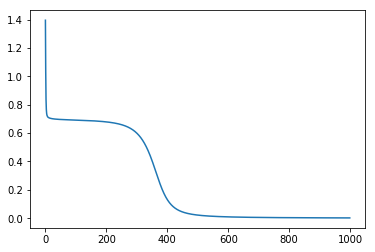

In [11]:
# debug set
net_full = Lin_Net(8, 4, 64, 64, act_function)
plot = train(train_loader_debug, net_full, 1000, criterion, 100, "../logs/debug", cuda, 0.1)
plt.plot([item[0] for item in plot], [item[1] for item in plot])
test(test_loader_debug, net_full, criterion, 100, "../logs/debug", cuda)

batch: 1/1 in epoch 1/1000 
... loss: 1.3776636123657227

batch: 1/1 in epoch 2/1000 
... loss: 1.2420530319213867

batch: 1/1 in epoch 3/1000 
... loss: 1.0579910278320312

batch: 1/1 in epoch 4/1000 
... loss: 0.8742104172706604

batch: 1/1 in epoch 5/1000 
... loss: 0.7135658264160156

batch: 1/1 in epoch 6/1000 
... loss: 0.582996129989624

batch: 1/1 in epoch 7/1000 
... loss: 0.4809767007827759

batch: 1/1 in epoch 8/1000 
... loss: 0.4026193618774414

batch: 1/1 in epoch 9/1000 
... loss: 0.3425494432449341

batch: 1/1 in epoch 10/1000 
... loss: 0.29613444209098816

batch: 1/1 in epoch 11/1000 
... loss: 0.2597839832305908

batch: 1/1 in epoch 12/1000 
... loss: 0.23085461556911469

batch: 1/1 in epoch 13/1000 
... loss: 0.20744377374649048

batch: 1/1 in epoch 14/1000 
... loss: 0.1881902515888214

batch: 1/1 in epoch 15/1000 
... loss: 0.17211714386940002

batch: 1/1 in epoch 16/1000 
... loss: 0.15851622819900513

batch: 1/1 in epoch 17/1000 
... loss: 0.14686760306358337

b

batch: 1/1 in epoch 161/1000 
... loss: 0.011855028569698334

batch: 1/1 in epoch 162/1000 
... loss: 0.011777333915233612

batch: 1/1 in epoch 163/1000 
... loss: 0.01170063391327858

batch: 1/1 in epoch 164/1000 
... loss: 0.011624989099800587

batch: 1/1 in epoch 165/1000 
... loss: 0.011550339870154858

batch: 1/1 in epoch 166/1000 
... loss: 0.011476568877696991

batch: 1/1 in epoch 167/1000 
... loss: 0.011403735727071762

batch: 1/1 in epoch 168/1000 
... loss: 0.011331722140312195

batch: 1/1 in epoch 169/1000 
... loss: 0.011260705068707466

batch: 1/1 in epoch 170/1000 
... loss: 0.011190509423613548

batch: 1/1 in epoch 171/1000 
... loss: 0.011121073737740517

batch: 1/1 in epoch 172/1000 
... loss: 0.011052576825022697

batch: 1/1 in epoch 173/1000 
... loss: 0.01098489947617054

batch: 1/1 in epoch 174/1000 
... loss: 0.010918045416474342

batch: 1/1 in epoch 175/1000 
... loss: 0.010852009989321232

batch: 1/1 in epoch 176/1000 
... loss: 0.01078661996871233

batch: 1/1 

batch: 1/1 in epoch 301/1000 
... loss: 0.00612234603613615

batch: 1/1 in epoch 302/1000 
... loss: 0.006101078353822231

batch: 1/1 in epoch 303/1000 
... loss: 0.006079810205847025

batch: 1/1 in epoch 304/1000 
... loss: 0.006058778613805771

batch: 1/1 in epoch 305/1000 
... loss: 0.006037924438714981

batch: 1/1 in epoch 306/1000 
... loss: 0.00601718807592988

batch: 1/1 in epoch 307/1000 
... loss: 0.005996569991111755

batch: 1/1 in epoch 308/1000 
... loss: 0.005976010579615831

batch: 1/1 in epoch 309/1000 
... loss: 0.005955747328698635

batch: 1/1 in epoch 310/1000 
... loss: 0.005935483146458864

batch: 1/1 in epoch 311/1000 
... loss: 0.005915396846830845

batch: 1/1 in epoch 312/1000 
... loss: 0.005895428359508514

batch: 1/1 in epoch 313/1000 
... loss: 0.005875636823475361

batch: 1/1 in epoch 314/1000 
... loss: 0.005855964031070471

batch: 1/1 in epoch 315/1000 
... loss: 0.005836468189954758

batch: 1/1 in epoch 316/1000 
... loss: 0.005817031487822533

batch: 1/1

batch: 1/1 in epoch 466/1000 
... loss: 0.0038682410959154367

batch: 1/1 in epoch 467/1000 
... loss: 0.003859572345390916

batch: 1/1 in epoch 468/1000 
... loss: 0.0038509629666805267

batch: 1/1 in epoch 469/1000 
... loss: 0.003842353355139494

batch: 1/1 in epoch 470/1000 
... loss: 0.003833743743598461

batch: 1/1 in epoch 471/1000 
... loss: 0.0038251937367022038

batch: 1/1 in epoch 472/1000 
... loss: 0.0038168213795870543

batch: 1/1 in epoch 473/1000 
... loss: 0.003808271139860153

batch: 1/1 in epoch 474/1000 
... loss: 0.0037997798062860966

batch: 1/1 in epoch 475/1000 
... loss: 0.0037914076820015907

batch: 1/1 in epoch 476/1000 
... loss: 0.0037830350920557976

batch: 1/1 in epoch 477/1000 
... loss: 0.003774721873924136

batch: 1/1 in epoch 478/1000 
... loss: 0.0037665273994207382

batch: 1/1 in epoch 479/1000 
... loss: 0.003758273320272565

batch: 1/1 in epoch 480/1000 
... loss: 0.003750019473955035

batch: 1/1 in epoch 481/1000 
... loss: 0.00374182453379035

b

batch: 1/1 in epoch 610/1000 
... loss: 0.002916846191510558

batch: 1/1 in epoch 611/1000 
... loss: 0.0029119134414941072

batch: 1/1 in epoch 612/1000 
... loss: 0.0029069213196635246

batch: 1/1 in epoch 613/1000 
... loss: 0.0029019289650022984

batch: 1/1 in epoch 614/1000 
... loss: 0.002896936610341072

batch: 1/1 in epoch 615/1000 
... loss: 0.002891944255679846

batch: 1/1 in epoch 616/1000 
... loss: 0.0028871302492916584

batch: 1/1 in epoch 617/1000 
... loss: 0.002882137894630432

batch: 1/1 in epoch 618/1000 
... loss: 0.0028772642835974693

batch: 1/1 in epoch 619/1000 
... loss: 0.002872450277209282

batch: 1/1 in epoch 620/1000 
... loss: 0.0028675172943621874

batch: 1/1 in epoch 621/1000 
... loss: 0.0028627626597881317

batch: 1/1 in epoch 622/1000 
... loss: 0.0028578294441103935

batch: 1/1 in epoch 623/1000 
... loss: 0.002853074576705694

batch: 1/1 in epoch 624/1000 
... loss: 0.0028482009656727314

batch: 1/1 in epoch 625/1000 
... loss: 0.002843565074726939


batch: 1/1 in epoch 745/1000 
... loss: 0.0023657092824578285

batch: 1/1 in epoch 746/1000 
... loss: 0.0023624387104064226

batch: 1/1 in epoch 747/1000 
... loss: 0.0023590493947267532

batch: 1/1 in epoch 748/1000 
... loss: 0.002355719218030572

batch: 1/1 in epoch 749/1000 
... loss: 0.0023525082506239414

batch: 1/1 in epoch 750/1000 
... loss: 0.0023492970503866673

batch: 1/1 in epoch 751/1000 
... loss: 0.0023459075018763542

batch: 1/1 in epoch 752/1000 
... loss: 0.002342637162655592

batch: 1/1 in epoch 753/1000 
... loss: 0.0023393663577735424

batch: 1/1 in epoch 754/1000 
... loss: 0.00233609601855278

batch: 1/1 in epoch 755/1000 
... loss: 0.002332884818315506

batch: 1/1 in epoch 756/1000 
... loss: 0.002329673618078232

batch: 1/1 in epoch 757/1000 
... loss: 0.0023264624178409576

batch: 1/1 in epoch 758/1000 
... loss: 0.0023232512176036835

batch: 1/1 in epoch 759/1000 
... loss: 0.0023200400173664093

batch: 1/1 in epoch 760/1000 
... loss: 0.002316828817129135


batch: 1/1 in epoch 924/1000 
... loss: 0.0018882198492065072

batch: 1/1 in epoch 925/1000 
... loss: 0.001886078156530857

batch: 1/1 in epoch 926/1000 
... loss: 0.0018839363474398851

batch: 1/1 in epoch 927/1000 
... loss: 0.0018818541429936886

batch: 1/1 in epoch 928/1000 
... loss: 0.0018797124503180385

batch: 1/1 in epoch 929/1000 
... loss: 0.00187763012945652

batch: 1/1 in epoch 930/1000 
... loss: 0.0018754885531961918

batch: 1/1 in epoch 931/1000 
... loss: 0.0018734061159193516

batch: 1/1 in epoch 932/1000 
... loss: 0.0018712644232437015

batch: 1/1 in epoch 933/1000 
... loss: 0.001869182102382183

batch: 1/1 in epoch 934/1000 
... loss: 0.001867040409706533

batch: 1/1 in epoch 935/1000 
... loss: 0.0018649580888450146

batch: 1/1 in epoch 936/1000 
... loss: 0.0018629948608577251

batch: 1/1 in epoch 937/1000 
... loss: 0.0018608530517667532

batch: 1/1 in epoch 938/1000 
... loss: 0.0018587112426757812

batch: 1/1 in epoch 939/1000 
... loss: 0.001856688410043716

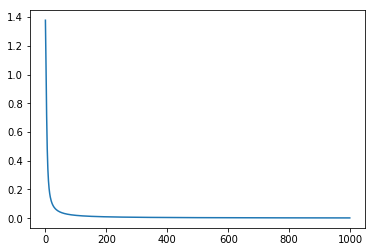

In [30]:
# create nets
print("creating nets")
print("-------- net_lin_emotion_full")
net_full = Lin_Net(8, 4, 64, 64, act_function)
train(train_loader_emotion_full, net_full, 100, criterion, 5000, "../logs/net_lin_emotion_full", cuda, 0.1)
test(test_loader_emotion_full, net_full, criterion, 1000, "../logs/net_lin_emotion_full")
print("-------- net_lin_emotion_nolex")
net_half = Lin_Net(4, 4, 64, 64, act_function)
train(train_loader_emotion_nolex, net_half, 100, criterion, 5000, "../logs/net_lin_emotion_nolex", cuda, 0.1)
test(test_loader_emotion_nolex, net_half, criterion, 1000, "../logs/net_lin_emotion_nolex")
print("-------- net_lin_emotion_lex")
net_half = Lin_Net(4, 4, 64, 64, act_function)
train(train_loader_emotion_lex, net_half, 100, criterion, 5000, "../logs/net_lin_emotion_lex", cuda, 0.1)
test(test_loader_emotion_lex, net_half, criterion, 1000, "../logs/net_lin_emotion_lex")
print("-------- net_lin_emotion_full")
net_full = Lin_Net(8, 4, 64, 64, act_function)
train(train_loader_tweet_full, net_full, 100, criterion, 5000, "../logs/net_tweet_full", cuda, 0.1)
test(test_loader_tweet_full, net_full, criterion, 1000, "../logs/net_lin_tweet_full")
print("-------- net_lin_tweet_nolex")
net_half = Lin_Net(4, 4, 64, 64, act_function)
train(train_loader_tweet_nolex, net_half, 100, criterion, 5000, "../logs/net_tweet_nolex", cuda, 0.1)
test(test_loader_tweet_nolex, net_half, criterion, 1000, "../logs/net_lin_tweet_nolex")
print("-------- net_lin_tweet_lex")
net_half = Lin_Net(4, 4, 64, 64, act_function)
train(train_loader_tweet_lex, net_half, 100, criterion, 5000, "../logs/net_tweet_lex", cuda, 0.1)
test(test_loader_tweet_lex, net_half, criterion, 1000, "../logs/net_lin_tweet_lex")